In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#new_path = r'/home/ochernytska/diploma/hand-pose/'
#sys.path.append(new_path)

In [3]:
import numpy as np
from dataset import get_dataloader
from model import get_model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch
from torchvision import models
import yaml
import json
from utils import visualize_2d, heatmaps_to_coordinates, visualize_3d
import pandas as pd

## Evaluation 2D

In [4]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e010= json.load(fp)

file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e010_2= json.load(fp)
    
experiment = 'e012'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e012 = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e012_2= json.load(fp)

In [5]:
df_total = pd.DataFrame({'model1_synthhands': data_e010['error_total_2d'],
                     'model2_synthhands': data_e012['error_total_2d'],
                     'model1_ganerated': data_e010_2['error_total_2d'],
                     'model2_ganerated': data_e012_2['error_total_2d'],
                     'level1': '6 total',
                     'level2': '6 total'
                    }, index = [0])

df_total

,level1,level2,model1_ganerated,model1_synthhands,model2_ganerated,model2_synthhands
0,6 total,6 total,0.034021,0.019834,0.039883,0.02695


In [7]:
df2 = pd.DataFrame({'model1_synthhands': data_e010['error_keypoint_2d'],
                     'model2_synthhands': data_e012['error_keypoint_2d'],
                     'model1_ganerated': data_e010_2['error_keypoint_2d'],
                     'model2_ganerated': data_e012_2['error_keypoint_2d']
                    })
df2['keypoint_num'] = np.arange(1,22)
df2['finger'] = ['0 wrist'] + ['1 thumb']*4 + ['2 index']*4 +['3 middle']*4 + ['4 ring']*4 + ['5 little']*4
df2['joint'] = ['0 wrist'] + ['1 MCP', '2 PIP', '3 DIP', '4 fingertip']*5

error_finger = df2.groupby('finger').agg({'model1_ganerated': np.mean,
                           'model2_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model2_synthhands': np.mean})
error_finger = error_finger.reset_index()
error_finger['level1'] = '2 finger'
error_finger['level2'] = error_finger['finger']
error_finger = error_finger.drop(columns = ['finger'])
error_finger

,model1_ganerated,model2_synthhands,model2_ganerated,model1_synthhands,level1,level2
0,0.027069,0.017922,0.035791,0.008500,2 finger,0 wrist
1,0.027220,0.022586,0.036252,0.013812,2 finger,1 thumb
2,0.032294,0.025619,0.037164,0.018913,2 finger,2 index
3,0.035043,0.027344,0.040141,0.021037,2 finger,3 middle
4,0.039848,0.031556,0.044838,0.024967,2 finger,4 ring
5,0.037438,0.029901,0.042046,0.023274,2 finger,5 little


In [8]:
error_joint = df2.groupby('joint').agg({'model1_ganerated': np.mean,
                           'model2_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model2_synthhands': np.mean})
error_joint = error_joint.reset_index()
error_joint['level1'] = '1 joint'
error_joint['level2'] = error_joint['joint']
error_joint = error_joint.drop(columns = ['joint'])
error_joint

,model1_ganerated,model2_synthhands,model2_ganerated,model1_synthhands,level1,level2
0,0.027069,0.017922,0.035791,0.008500,1 joint,0 wrist
1,0.022103,0.016513,0.029500,0.008988,1 joint,1 MCP
2,0.029253,0.024000,0.036534,0.016977,1 joint,2 PIP
3,0.036490,0.030503,0.042272,0.023603,1 joint,3 DIP
4,0.049629,0.038589,0.052047,0.032034,1 joint,4 fingertip


In [9]:
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = df_final.drop_duplicates(subset=['level2'])
df_final.loc[df_final['level2']=='0 wrist', 'level1'] = '0 wrist'
df_final.index = [np.array(df_final['level1']), np.array(df_final['level2'])]
df_final = df_final[df_final.columns[:4]]
df_final = df_final.sort_index()
df_final = df_final[['model1_synthhands','model2_synthhands','model1_ganerated','model2_ganerated']]

df_final.columns = [['SynthHands','SynthHands','Ganerated','Ganerated'],
                    ['Model 1','Model 2','Model 1','Model 2']]
for col in df_final.columns:
    df_final[col] = np.round(df_final[col],3)
    
df_final

SynthHands         Ganerated        
                        Model 1 Model 2   Model 1 Model 2
0 wrist  0 wrist          0.008   0.018     0.027   0.036
1 joint  1 MCP            0.009   0.017     0.022   0.029
         2 PIP            0.017   0.024     0.029   0.037
         3 DIP            0.024   0.031     0.036   0.042
         4 fingertip      0.032   0.039     0.050   0.052
2 finger 1 thumb          0.014   0.023     0.027   0.036
         2 index          0.019   0.026     0.032   0.037
         3 middle         0.021   0.027     0.035   0.040
         4 ring           0.025   0.032     0.040   0.045
         5 little         0.023   0.030     0.037   0.042
6 total  6 total          0.020   0.027     0.034   0.040

In [12]:
with open('file.txt', 'w') as fp:
    fp.write(df_final.to_latex())

#### Object vs NoObject Evaluation

In [13]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_object_valuation.json'
with open(file, 'r') as fp:
    data_e010_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/synth_hands_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e010_noobj = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_object_valuation.json'
with open(file, 'r') as fp:
    data_e010_2_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e010_2_noobj = json.load(fp)
    
experiment = 'e012'
file = 'experiment/' + experiment + '/synth_hands_object_valuation.json'
with open(file, 'r') as fp:
    data_e012_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/synth_hands_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e012_noobj = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_object_valuation.json'
with open(file, 'r') as fp:
    data_e012_2_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e012_2_noobj = json.load(fp)

In [14]:
df = pd.DataFrame({'model1_synthhands': [data_e010_obj['error_total_2d'], 
                                         data_e010_noobj['error_total_2d']], 
                   'model2_synthhands': [data_e012_obj['error_total_2d'], 
                                         data_e012_noobj['error_total_2d']], 
                   'model1_ganerated': [data_e010_2_obj['error_total_2d'], 
                                         data_e010_2_noobj['error_total_2d']], 
                   'model2_ganerated': [data_e012_2_obj['error_total_2d'], 
                                         data_e012_2_noobj['error_total_2d']]
                  }, index = ['object','no object'])

df = df[['model1_synthhands','model2_synthhands','model1_ganerated','model2_ganerated']]

df.columns = [['SynthHands','SynthHands','Ganerated','Ganerated'],
                    ['Model 1','Model 2','Model 1','Model 2']]
for col in df.columns:
    df[col] = np.round(df[col],3)

df = df.sort_index()
df

SynthHands         Ganerated        
             Model 1 Model 2   Model 1 Model 2
no object      0.017   0.024     0.028   0.033
object         0.022   0.030     0.039   0.046

In [15]:
with open('file.txt', 'w') as fp:
    fp.write(df.to_latex())

## Evaluation 3D

In [16]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e010= json.load(fp)

file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e010_2= json.load(fp)
    
experiment = 'e013'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e013 = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e013_2= json.load(fp)

In [17]:
df_total = pd.DataFrame({'model1_synthhands': data_e010['error_total_3d'],
                     'model3_synthhands': data_e013['error_total_3d'],
                     'model1_ganerated': data_e010_2['error_total_3d'],
                     'model3_ganerated': data_e013_2['error_total_3d'],
                     'level1': '6 total',
                     'level2': '6 total'
                    }, index = [0])

df_total

,level1,level2,model1_ganerated,model1_synthhands,model3_ganerated,model3_synthhands
0,6 total,6 total,0.153422,0.137482,0.151484,0.138207


In [18]:
df2 = pd.DataFrame({'model1_synthhands': data_e010['error_keypoint_3d'],
                     'model3_synthhands': data_e013['error_keypoint_3d'],
                     'model1_ganerated': data_e010_2['error_keypoint_3d'],
                     'model3_ganerated': data_e013_2['error_keypoint_3d']
                    })
df2['keypoint_num'] = np.arange(1,22)
df2['finger'] = ['0 wrist'] + ['1 thumb']*4 + ['2 index']*4 +['3 middle']*4 + ['4 ring']*4 + ['5 little']*4
df2['joint'] = ['0 wrist'] + ['1 MCP', '2 PIP', '3 DIP', '4 fingertip']*5

In [19]:
error_finger = df2.groupby('finger').agg({'model1_ganerated': np.mean,
                           'model3_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model3_synthhands': np.mean})
error_finger = error_finger.reset_index()
error_finger['level1'] = '2 finger'
error_finger['level2'] = error_finger['finger']
error_finger = error_finger.drop(columns = ['finger'])
error_finger

,model3_synthhands,model1_ganerated,model3_ganerated,model1_synthhands,level1,level2
0,0.097510,0.141738,0.142870,0.098481,2 finger,0 wrist
1,0.139947,0.181888,0.180632,0.133159,2 finger,1 thumb
2,0.136013,0.141111,0.140639,0.134121,2 finger,2 index
3,0.123935,0.137006,0.129220,0.129534,2 finger,3 middle
4,0.151070,0.150260,0.150470,0.149226,2 finger,4 ring
5,0.150245,0.159766,0.158612,0.151123,2 finger,5 little


In [20]:
error_joint = df2.groupby('joint').agg({'model1_ganerated': np.mean,
                           'model3_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model3_synthhands': np.mean})
error_joint = error_joint.reset_index()
error_joint['level1'] = '1 joint'
error_joint['level2'] = error_joint['joint']
error_joint = error_joint.drop(columns = ['joint'])
error_joint

,model3_synthhands,model1_ganerated,model3_ganerated,model1_synthhands,level1,level2
0,0.097510,0.141738,0.142870,0.098481,1 joint,0 wrist
1,0.046980,0.064262,0.061784,0.047287,1 joint,1 MCP
2,0.114121,0.126815,0.125813,0.113213,1 joint,2 PIP
3,0.169413,0.182182,0.180138,0.168511,1 joint,3 DIP
4,0.230454,0.242766,0.239923,0.228719,1 joint,4 fingertip


In [21]:
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = df_final.drop_duplicates(subset=['level2'])
df_final.loc[df_final['level2']=='0 wrist', 'level1'] = '0 wrist'
df_final.index = [np.array(df_final['level1']), np.array(df_final['level2'])]
df_final = df_final[df_final.columns[:4]]
df_final = df_final.sort_index()
df_final = df_final[['model1_synthhands','model3_synthhands','model1_ganerated','model3_ganerated']]

In [22]:
df_final.columns = [['SynthHands','SynthHands','Ganerated','Ganerated'],
                    ['Model 1','Model 3','Model 1','Model 3']]
for col in df_final.columns:
    df_final[col] = np.round(df_final[col],3)
    
df_final

SynthHands         Ganerated        
                        Model 1 Model 3   Model 1 Model 3
0 wrist  0 wrist          0.098   0.098     0.142   0.143
1 joint  1 MCP            0.047   0.047     0.064   0.062
         2 PIP            0.113   0.114     0.127   0.126
         3 DIP            0.169   0.169     0.182   0.180
         4 fingertip      0.229   0.230     0.243   0.240
2 finger 1 thumb          0.133   0.140     0.182   0.181
         2 index          0.134   0.136     0.141   0.141
         3 middle         0.130   0.124     0.137   0.129
         4 ring           0.149   0.151     0.150   0.150
         5 little         0.151   0.150     0.160   0.159
6 total  6 total          0.137   0.138     0.153   0.151

In [23]:
with open('file.txt', 'w') as fp:
    fp.write(df_final.to_latex())

#### Object vs NoObject Evaluation

In [24]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_object_valuation.json'
with open(file, 'r') as fp:
    data_e010_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/synth_hands_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e010_noobj = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_object_valuation.json'
with open(file, 'r') as fp:
    data_e010_2_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e010_2_noobj = json.load(fp)
    
experiment = 'e013'
file = 'experiment/' + experiment + '/synth_hands_object_valuation.json'
with open(file, 'r') as fp:
    data_e013_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/synth_hands_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e013_noobj = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_object_valuation.json'
with open(file, 'r') as fp:
    data_e013_2_obj= json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_noobject_valuation.json'
with open(file, 'r') as fp:
    data_e013_2_noobj = json.load(fp)

In [25]:
df = pd.DataFrame({'model1_synthhands': [data_e010_obj['error_total_3d'], 
                                         data_e010_noobj['error_total_3d']], 
                   'model3_synthhands': [data_e013_obj['error_total_3d'], 
                                         data_e013_noobj['error_total_3d']], 
                   'model1_ganerated': [data_e010_2_obj['error_total_3d'], 
                                         data_e010_2_noobj['error_total_3d']], 
                   'model3_ganerated': [data_e013_2_obj['error_total_3d'], 
                                         data_e013_2_noobj['error_total_3d']]
                  }, index = ['object','no object'])

df = df[['model1_synthhands','model3_synthhands','model1_ganerated','model3_ganerated']]

df.columns = [['SynthHands','SynthHands','Ganerated','Ganerated'],
                    ['Model 1','Model 3','Model 1','Model 3']]
for col in df.columns:
    df[col] = np.round(df[col],3)

df = df.sort_index()
df

SynthHands         Ganerated        
             Model 1 Model 3   Model 1 Model 3
no object      0.114   0.116     0.136   0.134
object         0.161   0.161     0.167   0.164

In [26]:
with open('file.txt', 'w') as fp:
    fp.write(df.to_latex())

## Qualitative Evaluation

In [8]:
experiment = 'e010'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 16
cuda = int(config['cuda'])
config['dataset'] = 'synth_hands'
dataloader = get_dataloader(config, 'val')
model = get_model(config)
model.load_state_dict(torch.load(config['weights'])['model'])

FileNotFoundError: [Errno 2] No such file or directory: 'experiment/e010/config.yaml'

In [4]:
# calculating error for valuation dataset

names = []
errors_2d = []
errors_3d = []

for i, sample in enumerate(dataloader):
    
    if i % 50 == 0:
        print(i)
    
    
    sample['image'] = sample['image'].cuda(cuda)
    
    output = model(sample)
    
    out_2d = output['vector_2d'].detach().cpu()
    gt_2d = sample['vector_2d']
    
    out_3d = output['vector_3d'].detach().cpu()
    gt_3d = sample['vector_3d']
    
    this_names = sample['name']
    this_errors_2d = torch.sqrt(torch.mean((out_2d - gt_2d)**2, dim=1)).numpy()
    this_errors_3d = torch.sqrt(torch.mean((out_3d - gt_3d)**2, dim=1)).numpy()
    
    names.extend(this_names)
    errors_3d.extend(this_errors_3d)
    errors_2d.extend(this_errors_2d)

0


/home/ochernytska/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


50
100
150
200
250
300


In [5]:
# selecting images with highest and lowest errors
df = pd.DataFrame({'name': names, 'error_2d': errors_2d, 'error_3d': errors_3d})

df = df.sort_values(by = ['error_3d'])
df_small_error = df[:50].sample(10)

df = df.sort_values(by = ['error_3d'], ascending=False)
df_large_error = df[:50].sample(10)

In [6]:
df_small_error

,error_2d,error_3d,name
3521,0.006630,0.033611,/mnt/data/handpose/SynthHands_Release/female_n...
1206,0.002810,0.036022,/mnt/data/handpose/SynthHands_Release/male_noo...
1240,0.006478,0.037142,/mnt/data/handpose/SynthHands_Release/female_n...
439,0.004522,0.038359,/mnt/data/handpose/SynthHands_Release/female_n...
224,0.009711,0.039363,/mnt/data/handpose/SynthHands_Release/male_noo...
4756,0.020467,0.037825,/mnt/data/handpose/SynthHands_Release/male_noo...
4714,0.004713,0.036931,/mnt/data/handpose/SynthHands_Release/female_n...
4986,0.008640,0.036377,/mnt/data/handpose/SynthHands_Release/male_noo...
2626,0.004259,0.040345,/mnt/data/handpose/SynthHands_Release/female_n...
4417,0.010120,0.039391,/mnt/data/handpose/SynthHands_Release/female_n...


In [7]:
df_large_error

,error_2d,error_3d,name
3214,0.055743,0.403609,/mnt/data/handpose/SynthHands_Release/female_o...
746,0.026650,0.271880,/mnt/data/handpose/SynthHands_Release/male_obj...
4817,0.092656,0.388572,/mnt/data/handpose/SynthHands_Release/female_o...
1018,0.102660,0.484346,/mnt/data/handpose/SynthHands_Release/female_o...
4555,0.080249,0.417772,/mnt/data/handpose/SynthHands_Release/female_o...
4738,0.059689,0.275371,/mnt/data/handpose/SynthHands_Release/male_obj...
4968,0.101830,0.567698,/mnt/data/handpose/SynthHands_Release/female_o...
657,0.043987,0.277643,/mnt/data/handpose/SynthHands_Release/male_obj...
4518,0.112500,0.452586,/mnt/data/handpose/SynthHands_Release/female_o...
1552,0.081937,0.301487,/mnt/data/handpose/SynthHands_Release/male_noo...


In [8]:
def visualize_2d(images, names, df):

    plt.figure(figsize=(15,7))
    cols = 2
    rows = 5
    
    for i in range(10):
        img = images[i]
        name = names[i]
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        error_2d = float(df[df['name']==name]['error_2d'])
        error_3d = float(df[df['name']==name]['error_3d'])
        
        plt.subplot(cols,rows, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('2D error: {:.3f}\n3D error: {:.3f}'.format(error_2d, error_3d))
        
        
        
    
    plt.show()    
    return  

In [9]:
def show_error(df):
    names_list = list(df['name'])
    names = []
    images = []

    for i, sample in enumerate(dataloader):
        if i % 50 == 0:
            print(i)
            
        for j in range(len(sample['name'])):
            if sample['name'][j] in names_list:
                names.append(sample['name'][j])
                images.append(sample['image'][j])
                
    visualize_2d(images, names, df)


0
50
100
150
200
250
300


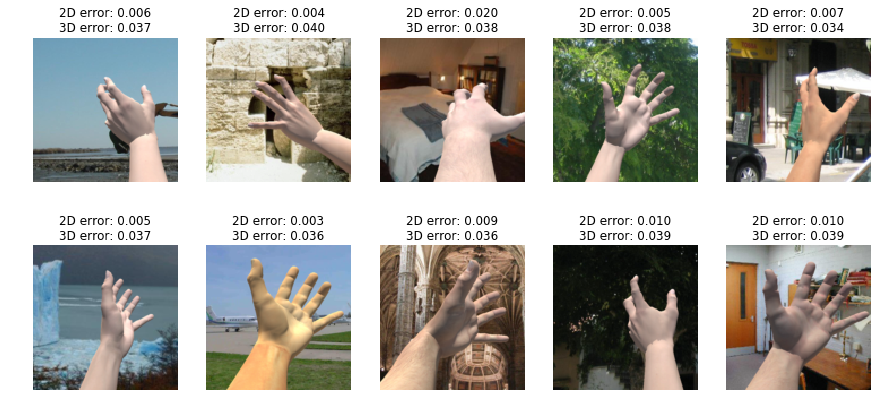

In [10]:
show_error(df_small_error)

0
50
100
150
200
250
300


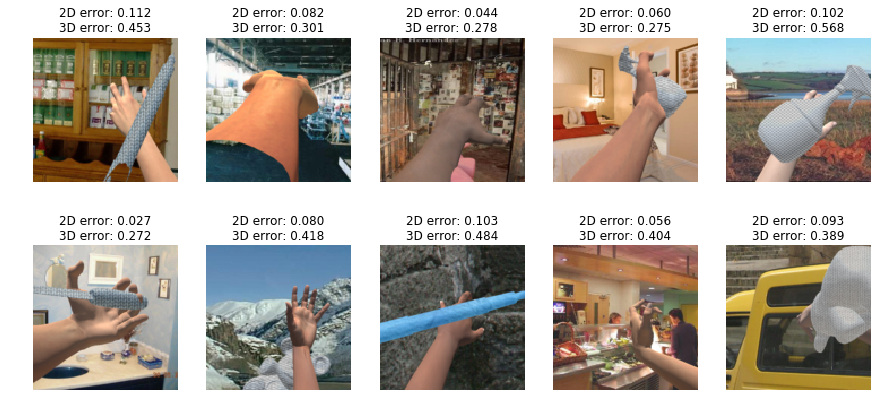

In [11]:
show_error(df_large_error)

## Augmentation Evaluation

In [27]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e010= json.load(fp)

file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e010_2= json.load(fp)
    
experiment = 'e020'
file = 'experiment/' + experiment + '/synth_hands_all_valuation.json'
with open(file, 'r') as fp:
    data_e020 = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_all_valuation.json'
with open(file, 'r') as fp:
    data_e020_2= json.load(fp)

In [28]:
df_total = pd.DataFrame({'dataset': ['SynthHands','GANerated'],
                         'e020_2d': [data_e020['error_total_2d'], data_e020_2['error_total_2d']],
                         'e020_3d': [data_e020['error_total_3d'], data_e020_2['error_total_3d']],
                         'e010_2d': [data_e010['error_total_2d'], data_e010_2['error_total_2d']],
                         'e010_3d': [data_e010['error_total_3d'], data_e010_2['error_total_3d']]
                        })

df_total.index = df_total['dataset']
df_total = df_total[df_total.columns[1:]]

df_total.columns = [['Before Augmentation', 'Before Augmentation',
                     'After Augmentation',  'After Augmentation'],
                    ['2D error','3D error','2D error','3D error']]
for col in df_total.columns:
    df_total[col] = np.round(df_total[col],3)

df1 = df_total

In [29]:
experiment = 'e010'
file = 'experiment/' + experiment + '/synth_hands_val_augment_valuation.json'
with open(file, 'r') as fp:
    data_e010= json.load(fp)

file = 'experiment/' + experiment + '/ganerated_val_augment_valuation.json'
with open(file, 'r') as fp:
    data_e010_2= json.load(fp)
    
experiment = 'e020'
file = 'experiment/' + experiment + '/synth_hands_val_augment_valuation.json'
with open(file, 'r') as fp:
    data_e020 = json.load(fp)
    
file = 'experiment/' + experiment + '/ganerated_val_augment_valuation.json'
with open(file, 'r') as fp:
    data_e020_2= json.load(fp)

In [30]:
df_total = pd.DataFrame({'dataset': ['SynthHands','GANerated'],
                         'e020_2d': [data_e020['error_total_2d'], data_e020_2['error_total_2d']],
                         'e020_3d': [data_e020['error_total_3d'], data_e020_2['error_total_3d']],
                         'e010_2d': [data_e010['error_total_2d'], data_e010_2['error_total_2d']],
                         'e010_3d': [data_e010['error_total_3d'], data_e010_2['error_total_3d']]
                        })

df_total.index = df_total['dataset']
df_total = df_total[df_total.columns[1:]]

df_total.columns = [['Before Augmentation', 'Before Augmentation',
                     'After Augmentation',  'After Augmentation'],
                    ['2D error','3D error','2D error','3D error']]
for col in df_total.columns:
    df_total[col] = np.round(df_total[col],3)

df2 = df_total


In [31]:
print('Non-augmented val set')
df1


Non-augmented val set


Before Augmentation          After Augmentation         
                      2D error 3D error           2D error 3D error
dataset                                                            
SynthHands               0.020    0.137              0.018    0.148
GANerated                0.034    0.153              0.026    0.144

In [33]:

print('Augmented val set')
df2

Augmented val set


Before Augmentation          After Augmentation         
                      2D error 3D error           2D error 3D error
dataset                                                            
SynthHands               0.119    0.697              0.020    0.165
GANerated                0.035    0.156              0.027    0.145

In [34]:
with open('file.txt', 'w') as fp:
    fp.write(df2.to_latex())

## Real Data Evaluation

In [218]:
experiment = 'e010'
file = 'experiment/' + experiment + '/stereo_valuation.json'
with open(file, 'r') as fp:
    data_e010= json.load(fp)

file = 'experiment/' + experiment + '/dexter+object_grasp2_valuation.json'
with open(file, 'r') as fp:
    data_e010_2= json.load(fp)
    
    
    
experiment = 'e020'
file = 'experiment/' + experiment + '/stereo_valuation.json'
with open(file, 'r') as fp:
    data_e020 = json.load(fp)
    
file = 'experiment/' + experiment + '/dexter+object_grasp2_valuation.json'
with open(file, 'r') as fp:
    data_e020_2= json.load(fp)

In [219]:
df_total = pd.DataFrame({'model1_synthhands': data_e010['error_total_2d'],
                     'model2_synthhands': data_e020['error_total_2d'],
                     'model1_ganerated': data_e010_2['error_total_2d'],
                     'model2_ganerated': data_e020_2['error_total_2d'],
                     'level1': '6 total',
                     'level2': '6 total'
                    }, index = [0])

df_total

,level1,level2,model1_ganerated,model1_synthhands,model2_ganerated,model2_synthhands
0,6 total,6 total,0.32168,0.1155,0.214181,0.098622


In [220]:
df2 = pd.DataFrame({'model1_synthhands': data_e010['error_keypoint_2d'],
                     'model2_synthhands': data_e020['error_keypoint_2d'],
                     'model1_ganerated': data_e010_2['error_keypoint_2d'],
                     'model2_ganerated': data_e020_2['error_keypoint_2d']
                    })
df2['keypoint_num'] = np.arange(1,22)
df2['finger'] = ['0 wrist'] + ['1 thumb']*4 + ['2 index']*4 +['3 middle']*4 + ['4 ring']*4 + ['5 little']*4
df2['joint'] = ['0 wrist'] + ['1 MCP', '2 PIP', '3 DIP', '4 fingertip']*5

error_finger = df2.groupby('finger').agg({'model1_ganerated': np.mean,
                           'model2_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model2_synthhands': np.mean})
error_finger = error_finger.reset_index()
error_finger['level1'] = '2 finger'
error_finger['level2'] = error_finger['finger']
error_finger = error_finger.drop(columns = ['finger'])
error_finger

,model1_ganerated,model1_synthhands,model2_synthhands,model2_ganerated,level1,level2
0,-1.000000,-1.000000,-1.000000,-1.000000,2 finger,0 wrist
1,-0.656709,0.118622,0.097380,-0.717421,2 finger,1 thumb
2,-0.654044,0.088626,0.080245,-0.686398,2 finger,2 index
3,-0.700906,0.108694,0.092723,-0.733083,2 finger,3 middle
4,-0.695656,0.130219,0.111283,-0.707974,2 finger,4 ring
5,-0.633285,0.131337,0.111480,-0.649356,2 finger,5 little


In [221]:
error_joint = df2.groupby('joint').agg({'model1_ganerated': np.mean,
                           'model2_ganerated': np.mean,
                           'model1_synthhands': np.mean,
                           'model2_synthhands': np.mean})
error_joint = error_joint.reset_index()
error_joint['level1'] = '1 joint'
error_joint['level2'] = error_joint['joint']
error_joint = error_joint.drop(columns = ['joint'])
error_joint

,model1_ganerated,model1_synthhands,model2_synthhands,model2_ganerated,level1,level2
0,-1.00000,-1.000000,-1.000000,-1.000000,1 joint,0 wrist
1,-1.00000,0.088279,0.079610,-1.000000,1 joint,1 MCP
2,-1.00000,0.101576,0.086947,-1.000000,1 joint,2 PIP
3,-1.00000,0.120121,0.100646,-1.000000,1 joint,3 DIP
4,0.32752,0.152023,0.127285,0.204615,1 joint,4 fingertip


In [222]:
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = pd.concat([error_finger,error_joint, df_total], sort=False)
df_final = df_final.drop_duplicates(subset=['level2'])
df_final.loc[df_final['level2']=='0 wrist', 'level1'] = '0 wrist'
df_final.index = [np.array(df_final['level1']), np.array(df_final['level2'])]
df_final = df_final[df_final.columns[:4]]
df_final = df_final.sort_index()
df_final = df_final[['model1_synthhands','model2_synthhands','model1_ganerated','model2_ganerated']]

df_final.columns = ['model1_stereo','model2_stereo','model1_dexter','model2_dexter']

df_final = df_final[['model1_stereo','model1_dexter']]

df_final.columns = ['Stereo','Dexter+Object']

for col in df_final.columns:
    df_final[col] = np.round(df_final[col],3)
    
df_final

Stereo  Dexter+Object
0 wrist  0 wrist      -1.000         -1.000
1 joint  1 MCP         0.088         -1.000
         2 PIP         0.102         -1.000
         3 DIP         0.120         -1.000
         4 fingertip   0.152          0.328
2 finger 1 thumb       0.119         -0.657
         2 index       0.089         -0.654
         3 middle      0.109         -0.701
         4 ring        0.130         -0.696
         5 little      0.131         -0.633
6 total  6 total       0.115          0.322

In [223]:
with open('file.txt', 'w') as fp:
    fp.write(df_final.to_latex())

In [224]:
df_comparison = pd.DataFrame({
        'Before Augmentation': [data_e010['error_total_2d'], data_e010_2['error_total_2d']],
        'After Augmentation': [data_e020['error_total_2d'], data_e020_2['error_total_2d']]},
        index =  ['Stereo','Dexter+Object'])

df_comparison = df_comparison[['Before Augmentation', 'After Augmentation']]

for col in df_comparison.columns:
    df_comparison[col] = np.round(df_comparison[col],3)
df_comparison

,Before Augmentation,After Augmentation
Stereo,0.115,0.099
Dexter+Object,0.322,0.214


In [225]:
with open('file.txt', 'w') as fp:
    fp.write(df_comparison.to_latex())

In [161]:
experiment = 'e022'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 16
cuda = int(config['cuda'])
config['dataset'] = 'dexter+object'
dataloader = get_dataloader(config, 'val')
model = get_model(config)
weights = 'experiment/' + experiment + '/' + config['weights']
model.load_state_dict(torch.load(weights)['model'])

Images in Dexter+Object dataset: 798. Augmentation: False


In [158]:
#model_22 = model

In [162]:
#sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)
#output_22 = model_22(sample)

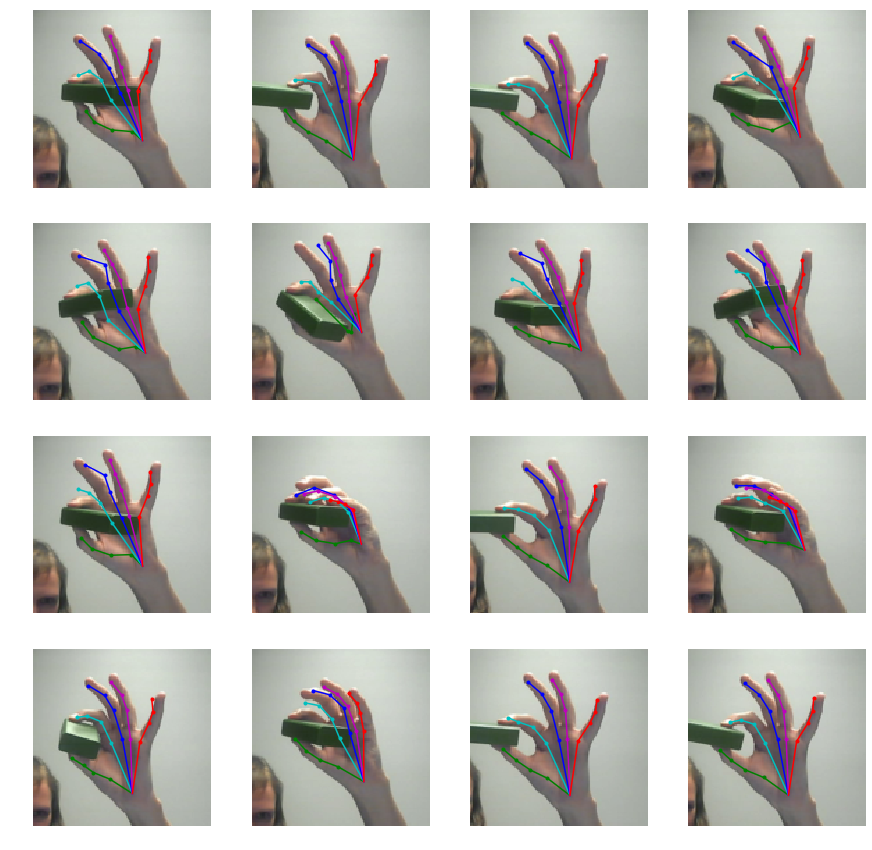

In [163]:
images = sample['image'].cpu()
vectors = output['vector_2d'].detach().cpu()
visualize_2d(images, vectors)

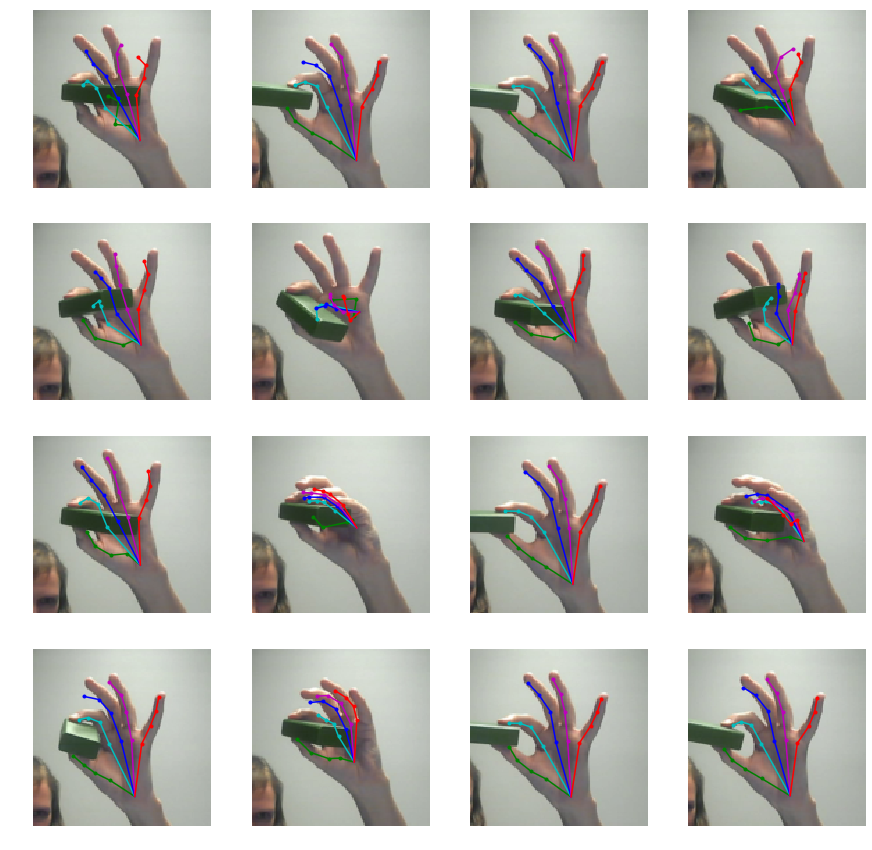

In [160]:
images = sample['image'].cpu()
vectors = output['vector_2d'].detach().cpu()
visualize_2d(images, vectors)

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
plotly.tools.set_credentials_file(username='chernytska', api_key='1AnqT3Fd6IKFHRGkoiri')

In [165]:
vectors = output['vector_3d'].detach().cpu()
arr = np.reshape(vectors[15].numpy(),(21,3))

In [166]:
colors = ['rgb(0,255,0)', 'rgb(135,206,250)', 
          'rgb(0,0,255)', 'rgb(255,105,180)', 'rgb(255,0,0)']

indices = [0,1,2,3,4]
thumb = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[0], size=4)
)

indices = [0,5,6,7,8]
index = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[1], size=4)
)

indices = [0,9,10,11,12]
middle = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[2], size=4)
)

indices = [0,13,14,15,16]
ring = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[3], size=4)
)

indices = [0,17,18,19,20]
little = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[4], size=4)
)

data = [thumb,index,middle,ring,little]

layout = go.Layout(
    
    scene = dict(
        xaxis=dict(range=[-2, 2]),
        yaxis=dict(range=[-2, 2]),
        zaxis=dict(range=[-2, 2]),
    )
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'basic-line')

## Numeric Evaluation: Final model

In [227]:
experiment = 'e020'
file = 'experiment/' + experiment + '/stereo_valuation.json'
with open(file, 'r') as fp:
    data_e020 = json.load(fp)
    
file = 'experiment/' + experiment + '/dexter+object_grasp2_valuation.json'
with open(file, 'r') as fp:
    data_e020_2 = json.load(fp)
    
file = 'experiment/' + experiment + '/dexter+object_grasp2_valuation.json'
with open(file, 'r') as fp:
    data_e020_3 = json.load(fp)
    
    
experiment = 'e023'
file = 'experiment/' + experiment + '/stereo_valuation.json'
with open(file, 'r') as fp:
    data_e022 = json.load(fp)

experiment = 'e022'
file = 'experiment/' + experiment + '/dexter+object_grasp2_valuation.json'
with open(file, 'r') as fp:
    data_e022_2 = json.load(fp)
    
file = 'experiment/' + experiment + '/dexter+object_rotate_valuation.json'
with open(file, 'r') as fp:
    data_e022_3 = json.load(fp)

    

In [232]:
df_comparison = pd.DataFrame({
        '2D error': [data_e020['error_total_2d'], data_e023['error_total_2d']]},
        index =  ['Synthetic Data','Stereo Dataset'])


df_comparison = pd.DataFrame({
        'Synthetic Data Only': [data_e020['error_total_2d'], data_e020_2['error_total_2d'],
                           data_e020_3['error_total_2d']],
        'Fine-tuning with Real Data': [data_e022['error_total_2d'], 
                          data_e022_2['error_total_2d'], data_e022_3['error_total_2d']],},
        index =  ['Stereo (B1Counting, B1Random)','Dexter (Grasp2)', 'Dexter (Rotate)'])

df_comparison = df_comparison[['Synthetic Data Only', 'Fine-tuning with Real Data']]

for col in df_comparison.columns:
    df_comparison[col] = np.round(df_comparison[col],3)
df_comparison

,Synthetic Data Only,Fine-tuning with Real Data
"Stereo (B1Counting, B1Random)",0.099,0.028
Dexter (Grasp2),0.214,0.058
Dexter (Rotate),0.214,0.043


In [233]:
with open('file.txt', 'w') as fp:
    fp.write(df_comparison.to_latex())

## Visul Evaluation: Final model

In [192]:
experiment = 'e022'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)
config['augment'] = 0
config['batch_size'] = 16
cuda = int(config['cuda'])
config['dataset'] = 'dexter+object'
dataloader = get_dataloader(config, 'train')
model = get_model(config)
weights = 'experiment/' + experiment + '/' + config['weights'] 
model.load_state_dict(torch.load(weights)['model'])

Images in Dexter+Object dataset: 2347. Augmentation: False


In [213]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)

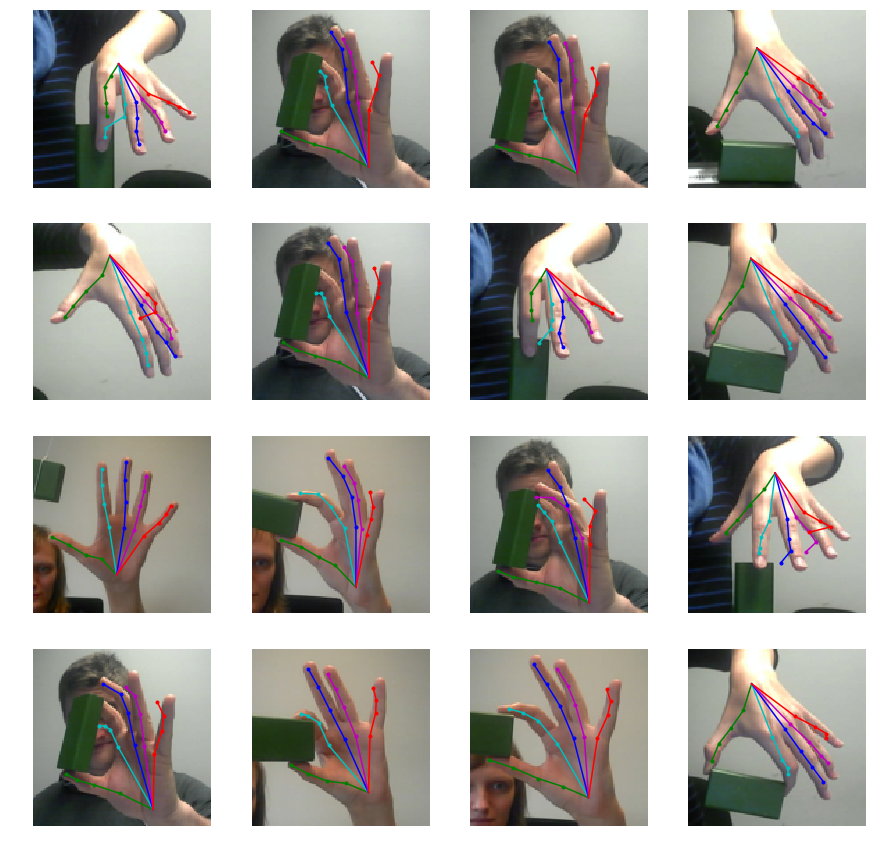

In [214]:
images = sample['image'].cpu()
vectors = output['vector_2d'].detach().cpu()
visualize_2d(images, vectors)

In [191]:
vectors = output['vector_3d'].detach().cpu()
arr = np.reshape(vectors[5].numpy(),(21,3))


colors = ['rgb(0,255,0)', 'rgb(135,206,250)', 
          'rgb(0,0,255)', 'rgb(255,105,180)', 'rgb(255,0,0)']

indices = [0,1,2,3,4]
thumb = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[0], size=4)
)

indices = [0,5,6,7,8]
index = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[1], size=4)
)

indices = [0,9,10,11,12]
middle = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[2], size=4)
)

indices = [0,13,14,15,16]
ring = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[3], size=4)
)

indices = [0,17,18,19,20]
little = go.Scatter3d(
    x = arr[indices,0],
    y = arr[indices,1],
    z = arr[indices,2],
    marker = dict(color=colors[4], size=4)
)

data = [thumb,index,middle,ring,little]

layout = go.Layout(
    
    scene = dict(
        xaxis=dict(range=[-2, 2]),
        yaxis=dict(range=[-2, 2]),
        zaxis=dict(range=[-2, 2]),
    )
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'basic-line')

## Final Comparison Table

In [45]:
experiment = 'e020'
file = 'experiment/' + experiment + '/ganerated_test_valuation.json'
with open(file, 'r') as fp:
    data_gan = json.load(fp)
    
file = 'experiment/' + experiment + '/synth_hands_test_valuation.json'
with open(file, 'r') as fp:
    data_synth = json.load(fp)
    
experiment = 'e023'
file = 'experiment/' + experiment + '/stereo_mm_valuation.json'
with open(file, 'r') as fp:
    data_stereo = json.load(fp)
    
experiment = 'e022'
file = 'experiment/' + experiment + '/dexter+object_rotate_mm_valuation.json'
with open(file, 'r') as fp:
    data_dexter = json.load(fp)

In [46]:
df = pd.DataFrame({'ours_2d error mm': [data_synth['error_total_2d']*480,data_gan['error_total_2d']*256,
                                        data_stereo['error_total_2d'],data_dexter['error_total_2d']],
                   #'ours_3d error norm': [data_synth['error_total_3d'],data_gan['error_total_3d'],None,None],
                   'Zimmernman': [None,None,5.522,25.16],
                   'GANerated': [None,None,None,19.263],
                   'Latent 2.5D': [None, None, None, 19.263]},
                  index=['SynthHands','GANerated', 
                               'Stereo TB', 'Dexter+Object'])

df = df[['ours_2d error mm','Zimmernman','GANerated', 'Latent 2.5D']]
for col in df.columns:
    df[col] = np.round(df[col],3)

print('Best performance for datasets')
df

Best performance for datasets


,ours_2d error mm,Zimmernman,GANerated,Latent 2.5D
SynthHands,8.760,NaN,NaN,NaN
GANerated,6.708,NaN,NaN,NaN
Stereo TB,6.078,5.522,NaN,NaN
Dexter+Object,11.360,25.160,19.263,19.263


In [47]:
with open('file.txt', 'w') as fp:
    fp.write(df.to_latex())